In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import itertools

In [2]:
dir_ = 'images/'
image_pathes = [os.path.join(dir_, im) for im in os.listdir(dir_)]
image_pathes

['images/lead_720_405.jpg',
 'images/file-20180206-14104-1hyhea9.jpg',
 'images/cats_and_bunnies.jpg',
 'images/cats-paw.jpg',
 'images/images (2).jpeg',
 'images/A-fluffy-cat-looking-funny-surprised-or-concerned.jpg',
 'images/images.jpeg',
 'images/images (1).jpeg',
 'images/download.jpeg',
 'images/1196500-0-20180830062128.jpeg']

In [3]:
# def get_img(url):
#     img = io.imread(url)
#     plt.imshow(img)
# #     img = img[:, :, :-1]
#     return img

# images = [get_img(im) for im in images]

In [4]:
def get_n_dominant_colors(img, n_colors=3):
#     average = img.mean(axis=0).mean(axis=0)
    pixels = np.float32(img.reshape(-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    return palette, counts

In [5]:
# dom = get_n_dominant_colors(images[-1])

In [6]:
POWER_CONST = 2
N_COLORS_CONST = 3

class Image:
    
    n_colors = N_COLORS_CONST
    
    def __init__(self, path):
#         img = io.imread(url)
#         plt.imshow(img)
#         img = img[:, :, :-1]
        self.img_body = io.imread(path)
        self.palette, self.counts = get_n_dominant_colors(self.img_body, Image.n_colors)
        self.indices = np.argsort(self.counts)[::-1] 
        self.dominants = ImageDominants(self.palette[self.indices])
        
    def plot_image(self):
        plt.imshow(self.img_body)
        
    def plot_dominants(self):
        freqs = np.cumsum(np.hstack([[0], self.counts[self.indices]/self.counts.sum()]))
        rows = np.int_(self.img_body.shape[0]*freqs)
        dom_patch = np.zeros(shape=self.img_body.shape, dtype=np.uint8)
        for i in range(len(rows) - 1):
            dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(self.palette[self.indices[i]])
        fig, (ax1) = plt.subplots(1, 1, figsize=(6,6))
        ax1.imshow(dom_patch)
        ax1.set_title('Dominant colors')
        ax1.axis('off')
        plt.show()
        
    def plot_image_and_dominants(self):
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
        ax0.imshow(self.img_body)
        ax0.set_title('Image')
        ax0.axis('off')
        # todo 
        freqs = np.cumsum(np.hstack([[0], self.counts[self.indices]/self.counts.sum()]))
        rows = np.int_(self.img_body.shape[0]*freqs)
        dom_patch = np.zeros(shape=self.img_body.shape, dtype=np.uint8)
        for i in range(len(rows) - 1):
            dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(self.palette[self.indices[i]])
        ax1.imshow(dom_patch)
        ax1.set_title('Dominant colors')
        ax1.axis('off')
        plt.show()
        
    def distance(self, other):
        return self.dominants.distance(other.dominants)

        
class ImageDominants:
    
    power = POWER_CONST
    
    def __init__(self, dominants):
        self.dominants = [Color(dominant) for dominant in dominants]
        
    @staticmethod
    def _distance(d1, d2):
        return np.sqrt(sum(abs(d1[i].distance(d2[i]))**ImageDominants.power for i in range(len(d1))))
        
    def distance(self, other_image):
        permutations1 = itertools.permutations(self.dominants)
        permutations2 = itertools.permutations(other_image.dominants)
#         permutations1 = [sorted(self.dominants, key=lambda x: x.tuple_())]
#         permutations2 = [sorted(other_image.dominants, key=lambda x: x.tuple_())]
        min_dist = 1e10
        for p1 in permutations1:
            for p2 in permutations2:
                d = self._distance(p1, p2)
                if d < min_dist:
                    min_dist = d      
        return min_dist
    
class Color:
    
    power = POWER_CONST
    
    def __init__(self, row):
        r, g, b = row
        self.r = r
        self.g = g
        self.b = b
    
    def distance(self, other_color):
        return np.sqrt(abs(self.r-other_color.r)**Color.power + abs(self.g-other_color.g)**Color.power + abs(self.b-other_color.b)**Color.power)
    
    def print_(self):
        print((self.r, self.g, self.b))
        
    def tuple_(self):
        return (self.r, self.g, self.b)

In [7]:
images = [Image(image) for image in image_pathes]

In [8]:
start_image = images[0]
order = [start_image]
images.remove(start_image)
remained = images
while len(remained):
#     print(len(remained))
    current = order[-1]
    min_dist = 1e20
    min_i = 1e20
    for i in range(len(remained)):
        d = current.distance(remained[i])
        if d < min_dist:
            min_dist = d
            min_i = i
    order.append(remained[min_i])
    remained = [remained[j] for j in range(len(remained)) if min_i != j]

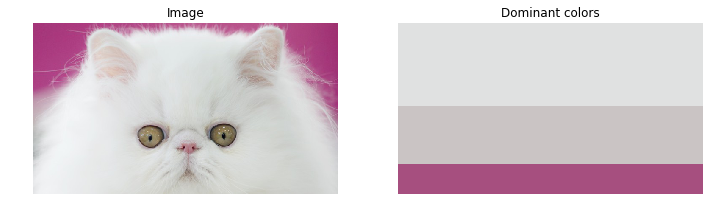

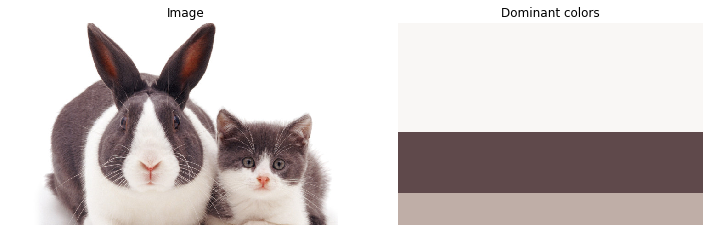

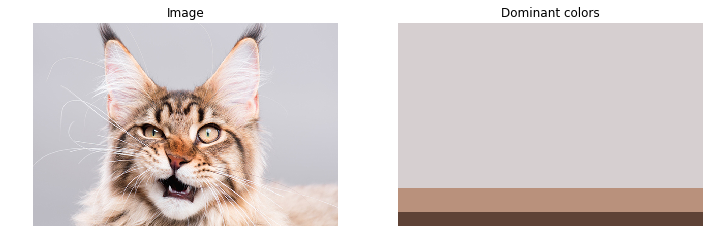

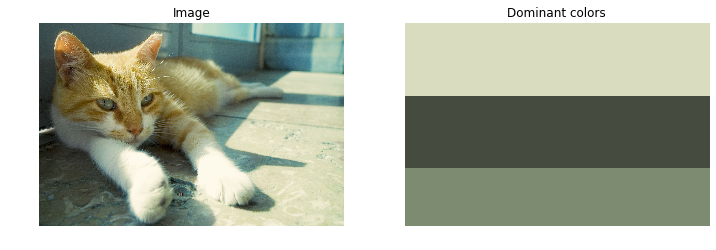

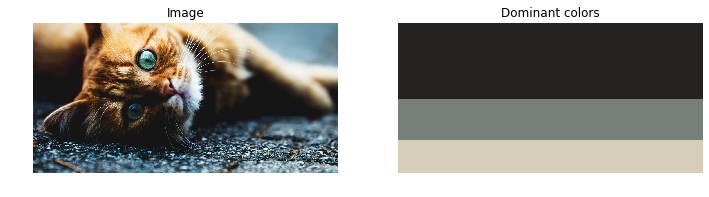

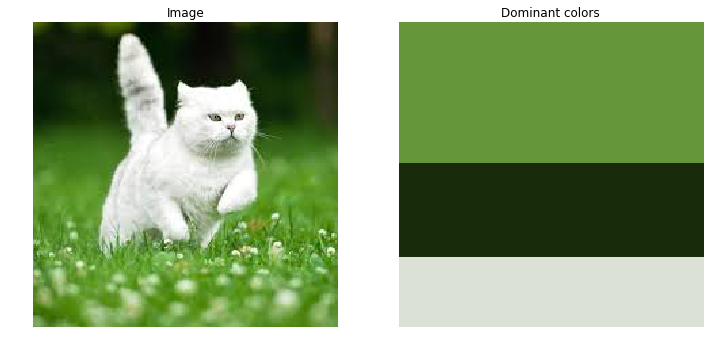

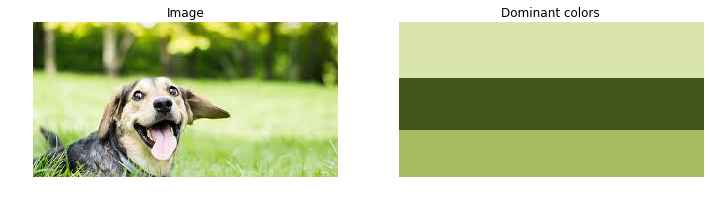

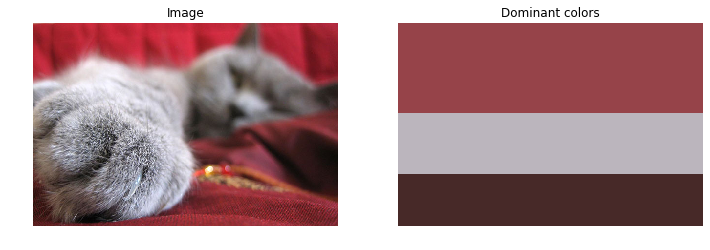

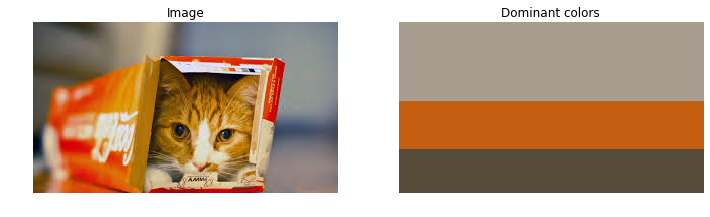

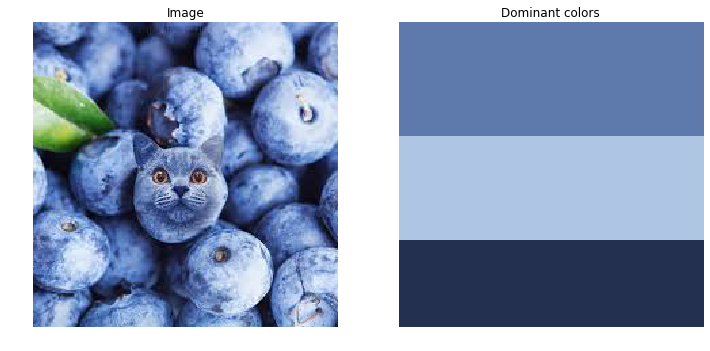

In [9]:
for im in order:
    im.plot_image_and_dominants()